
# LSTM Training on Kalman-Filtered Motion

This notebook trains a hybrid Kalman + LSTM model. The input sequences have already been passed through a Kalman filter (X_kalman.npy) before being used for training. The target output is still the smooth ground truth (Y_smooth.npy).

This approach allows the model to focus on correcting any residual noise left over from the Kalman filter.

- Input: Kalman-filtered motion data
- Output: smoothed ground truth
- Architecture: 2-layer LSTM + TimeDistributed Dense
- Loss: Mean Squared Error (MSE)
- Early stopping is used to select the best performing weights


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/MoSysProject/

/content/drive/MyDrive/MoSysProject


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

# Load motion data from .npy files
# X_kalman contains Kalman-filtered input sequences
# Y_smooth contains the target smoothed motion

X = np.load("/content/drive/MyDrive/MoSysProject/SyntheticData/X_kalman.npy")
Y = np.load("/content/drive/MyDrive/MoSysProject/SyntheticData/Y_smooth.npy")

print("Input shape:", X.shape)
print("Target shape:", Y.shape)


Input shape: (500, 124, 3)
Target shape: (500, 124, 3)


In [ ]:
# Define the LSTM model architecture
# The model takes sequences of 124 frames, each with 3 features (x, y, z)
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    LSTM(32, return_sequences=True),
    TimeDistributed(Dense(3))
])

# Compile the model using MSE loss and Adam optimizer
# MSE is good for measuring how far the predicted motion is from ground truth
model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 124, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 124, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 124, 3)         │            99 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,923 (116.89 KB)

 Trainable params: 29,923 (116.89 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model on the Kalman input vs. smooth output
# EarlyStopping stops training if the validation loss doesnt improve
history = model.fit(
    X, Y,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step - loss: 133.1884 - val_loss: 100.8311
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 92.7733 - val_loss: 76.1832
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 72.4074 - val_loss: 63.0206
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - loss: 60.3137 - val_loss: 53.2130
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - loss: 51.1151 - val_loss: 45.3533
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 43.4513 - val_loss: 38.8977
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - loss: 37.2467 - val_loss: 33.4854
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - loss: 32.1126 - val_loss: 28.9416
Epoch 9/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 27.7404 - val_loss: 25.0713
Epoch 10/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - loss: 23.9522 - val_loss: 21.7665
Epoch 11/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 20.9621 - val_loss: 18.9076
Epoch 12/30
29/29 ━━━━━━━━━

In [ ]:
# Save the model
os.makedirs("model", exist_ok=True)
model.save("/content/drive/MyDrive/MoSysProject/model/hybrid_kalman_lstm_model.h5")

print(" Model saved to model/hybrid_kalman_lstm_model.h5")


 Model saved to model/hybrid_kalman_lstm_model.h5


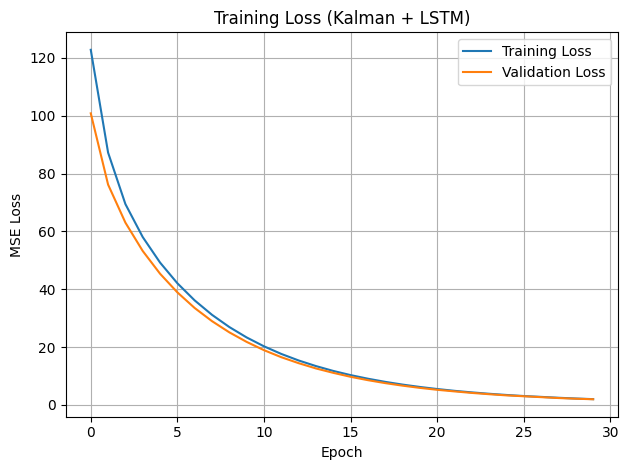

In [8]:
# Plot training and validation loss over time
# Helps to see if the model overfit or learned steadily
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training Loss (Kalman + LSTM)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
